<a href="https://colab.research.google.com/github/DrNelsonJatel/Testing-Social-Network-Metrics/blob/main/SNA_metrics_correlation_heatmap_standardized_betas_RM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

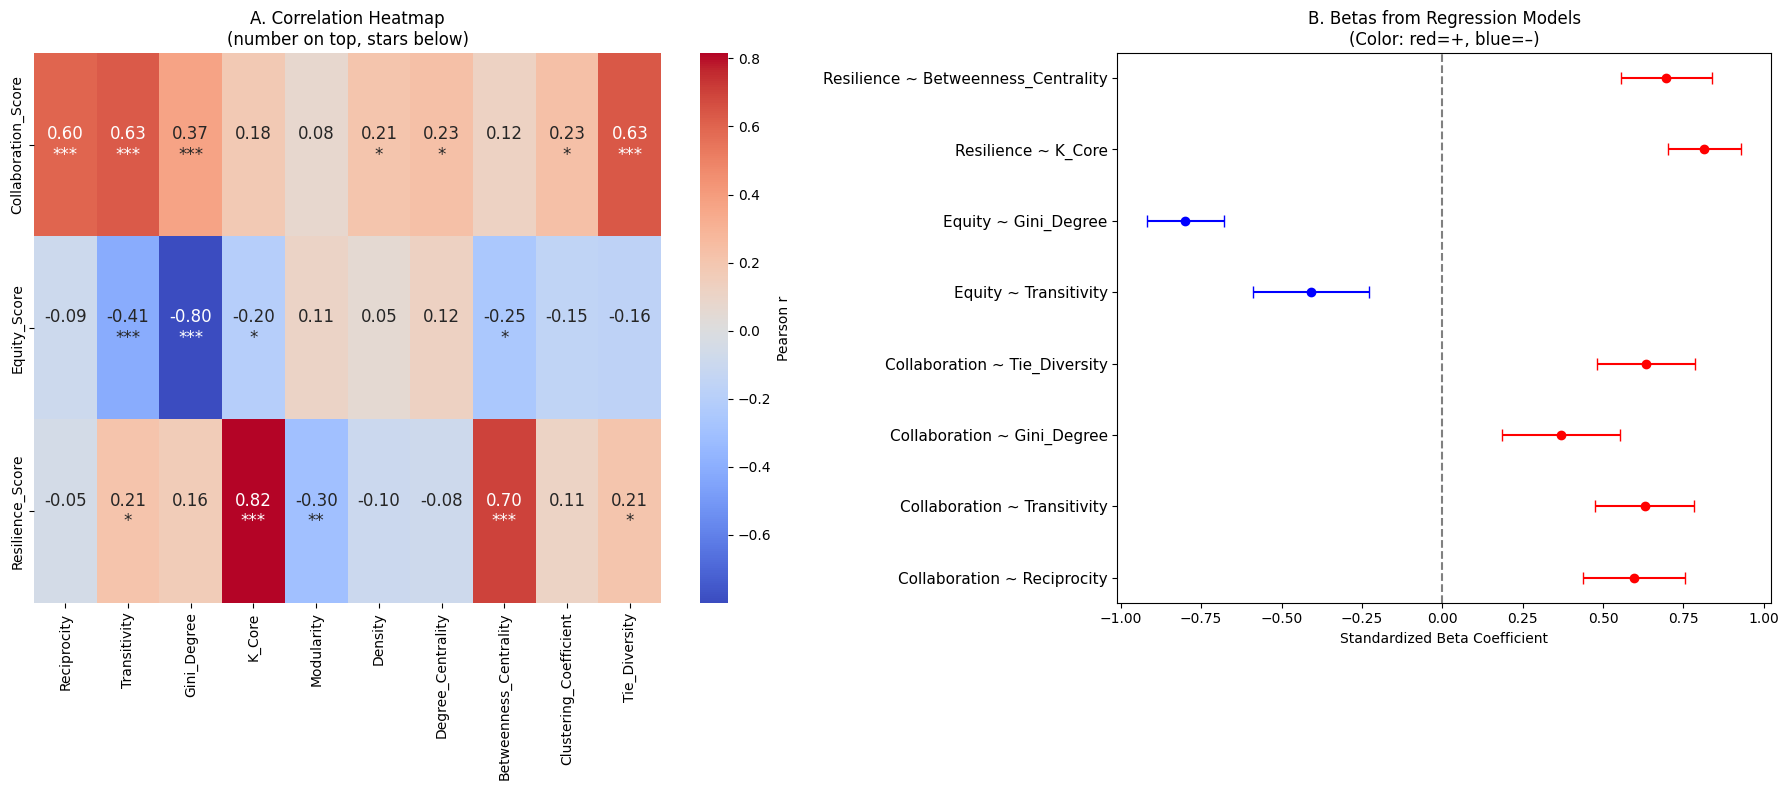

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Load your dataset (change path as needed)
df = pd.read_excel('final_extended_synthetic_governance_dataset.xlsx')

# Exact columns matching your dataset
outcomes = ["Collaboration_Score", "Equity_Score", "Resilience_Score"]
metrics = ["Reciprocity", "Transitivity", "Gini_Degree", "K_Core",
           "Modularity", "Density", "Degree_Centrality",
           "Betweenness_Centrality", "Clustering_Coefficient", "Tie_Diversity"]

# -------------------
# Compute correlations & p-values
# -------------------
corr_matrix = np.zeros((len(outcomes), len(metrics)))
p_matrix = np.zeros((len(outcomes), len(metrics)))

for i, out in enumerate(outcomes):
    for j, met in enumerate(metrics):
        r, p = pearsonr(df[out], df[met])
        corr_matrix[i, j] = r
        p_matrix[i, j] = p

# Prepare annotation matrix: number on top, stars below
stars_matrix = np.full_like(corr_matrix, '', dtype=object)
for i in range(len(outcomes)):
    for j in range(len(metrics)):
        p = p_matrix[i, j]
        if p < 0.001:
            stars_matrix[i, j] = '***'
        elif p < 0.01:
            stars_matrix[i, j] = '**'
        elif p < 0.05:
            stars_matrix[i, j] = '*'
        else:
            stars_matrix[i, j] = ''
annot_matrix = np.array([[f"{corr_matrix[i,j]:.2f}\n{stars_matrix[i,j]}"
                          for j in range(len(metrics))] for i in range(len(outcomes))])

# -------------------
# Prepare regression betas & SEs only for pairs with p < 0.001
# -------------------
selected_pairs = []
for i, out in enumerate(outcomes):
    for j, met in enumerate(metrics):
        if p_matrix[i, j] < 0.001:
            selected_pairs.append((out, met))

betas, errors, labels = [], [], []
for out, met in selected_pairs:
    X = df[[met]].values
    y = df[out].values
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.reshape(-1,1)).ravel()

    model = LinearRegression().fit(X_scaled, y_scaled)
    beta = model.coef_[0]
    pred = model.predict(X_scaled)
    residuals = y_scaled - pred
    se = np.sqrt(np.sum(residuals**2) / (len(y_scaled)-2)) / np.sqrt(np.sum((X_scaled - X_scaled.mean())**2))

    betas.append(beta)
    errors.append(se)
    labels.append(f"{out.replace('_Score','')} ~ {met}")

betas = np.array(betas)
errors = np.array(errors)

# -------------------
# Plot combined figure
# -------------------
fig, axes = plt.subplots(1, 2, figsize=(18, 8), gridspec_kw={'width_ratios': [1.2, 1]})

# Panel A: heatmap
sns.heatmap(corr_matrix, annot=annot_matrix, fmt='', cmap='coolwarm',
            xticklabels=metrics, yticklabels=outcomes, ax=axes[0],
            cbar_kws={'label': 'Pearson r'}, annot_kws={"size": 12})
axes[0].set_title("A. Correlation Heatmap\n(number on top, stars below)")

# Panel B: forest plot with color by sign
for i in range(len(betas)):
    color = 'red' if betas[i] > 0 else 'blue'
    axes[1].errorbar(betas[i], i, xerr=errors[i]*1.96, fmt='o', color=color, ecolor=color, capsize=4)

axes[1].axvline(0, color='grey', linestyle='--')
axes[1].set_yticks(range(len(labels)))
axes[1].set_yticklabels(labels, fontsize=11)
axes[1].set_xlabel("Standardized Beta Coefficient")
axes[1].set_title("B. Betas from Regression Models\n(Color: red=+, blue=–)")

plt.tight_layout()
plt.savefig("Enhanced_Combined_Heatmap_ForestPlot.png", dpi=400, bbox_inches='tight')
plt.show()
